In [85]:
%load_ext autoreload
%autoreload 2
import imageio
from robot_painting.pytorch_planar_scene_drawing import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
cuda = torch.device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
target_image_path = "../data/target.jpeg"
target_image = imageio.imread(target_image_path).astype(np.float)/256.
image_rows, image_cols, n_channels = target_image.shape

print("Rows: ", image_rows)
print("Cols: ", image_cols)

brush_search_paths = ["../data/brushes/*.png"]
# Open every image in that folder
brush_paths = sum([glob.glob(sp) for sp in brush_search_paths], [])
print("Found brushes: ", brush_paths)

raw_brushes = [imageio.imread(brush_path).astype(np.float) / 256. for brush_path in brush_paths]
raw_brushes = numpy_images_to_torch(raw_brushes).cuda()

Rows:  745
Cols:  1280
Found brushes:  ['../data/brushes/dry-brush-stroke-21.png']


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


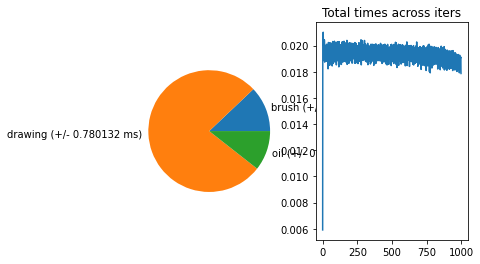

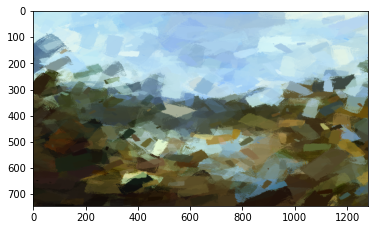

In [95]:
# Evaluate how long it takes to apply a brush to an image.
current_image = torch.ones(1, 3, image_rows, image_cols).cuda()
b2p, p2b = oilpaint_converters(device=torch.device('cuda'))

N_sprites_in_batch = 10
orig_brush_mask = raw_brushes[0][3, :].cuda()
brushes = torch.empty(N_sprites_in_batch, 4, orig_brush_mask.shape[0], orig_brush_mask.shape[1], device=cuda)
times = {
    "brush": [],
    "drawing": [],
    "oil": []
}
    
N_iters = 1000
for iter_k in tqdm(range(N_iters)):
    # Draw brush at random pose with random color.
    start_time = time.time()
    
    sprite_poses = torch.stack([
        torch.randint(low=int(-image_rows / 2), high=int(image_rows / 2), size=(N_sprites_in_batch,)),
        torch.randint(low=int(-image_cols / 2), high=int(image_cols / 2), size=(N_sprites_in_batch,)),
        torch.rand(N_sprites_in_batch) * np.pi * 2.
    ]).T
    # Random color + opacity.
    for k in range(N_sprites_in_batch):
        center = sprite_poses[k, 0:2]
        center_x = int(min(max(center[0].item() + (image_rows / 2), 0), image_rows))
        center_y = int(min(max(center[1].item() + (image_cols / 2), 0), image_cols))
        for i in range(3):
            brushes[k, i, :, :] = target_image[center_x, center_y, i]
        brushes[k, 3, :, :] = orig_brush_mask * torch.rand(1, device=cuda)
    post_brush_setup_time = time.time()
    
    sprites_scales = torch.rand(N_sprites_in_batch, 1) * np.sqrt((1. - float(iter_k) / N_iters))
    sprite_ims = draw_sprites_at_poses(
          sprite_poses, sprites_scales,
          brushes.shape[2], brushes.shape[3],
          image_rows, image_cols,
          brushes
    )
    
    post_drawing_time = time.time()
    
    # Reduce down to one image
    image_pre_oil = b2p(current_image)
    sprite_ims_oil = b2p(sprite_ims.cuda())
    # Permute for easier alpha combo
    image = image_pre_oil[0, :3, :, :]
    for k in range(sprite_ims_oil.shape[0]):
        alpha_map = 1. - sprite_ims_oil[k, 3, :, :]  # alphas inverted in absorb space
        image = image * (1 - alpha_map) + sprite_ims_oil[k, :3, :, :] * alpha_map
    current_image = p2b(image).unsqueeze(0)
    
    end_time = time.time()
    
    times["brush"].append(post_brush_setup_time - start_time)
    times["drawing"].append(post_drawing_time - post_brush_setup_time)
    times["oil"].append(end_time - post_drawing_time)
    
sizes = [np.mean(val)*1000 for val in times.values()]
total_times = sum([np.array(val) for val in times.values()])
labels = ["%s (+/- %f ms)" % (key, np.std(val)*1000) for key, val in times.items()]

plt.figure()
plt.subplot(1, 2, 1)
plt.pie(sizes, labels=labels, normalize=True)
plt.subplot(1, 2, 2)
plt.plot(total_times)
plt.title("Total times across iters")

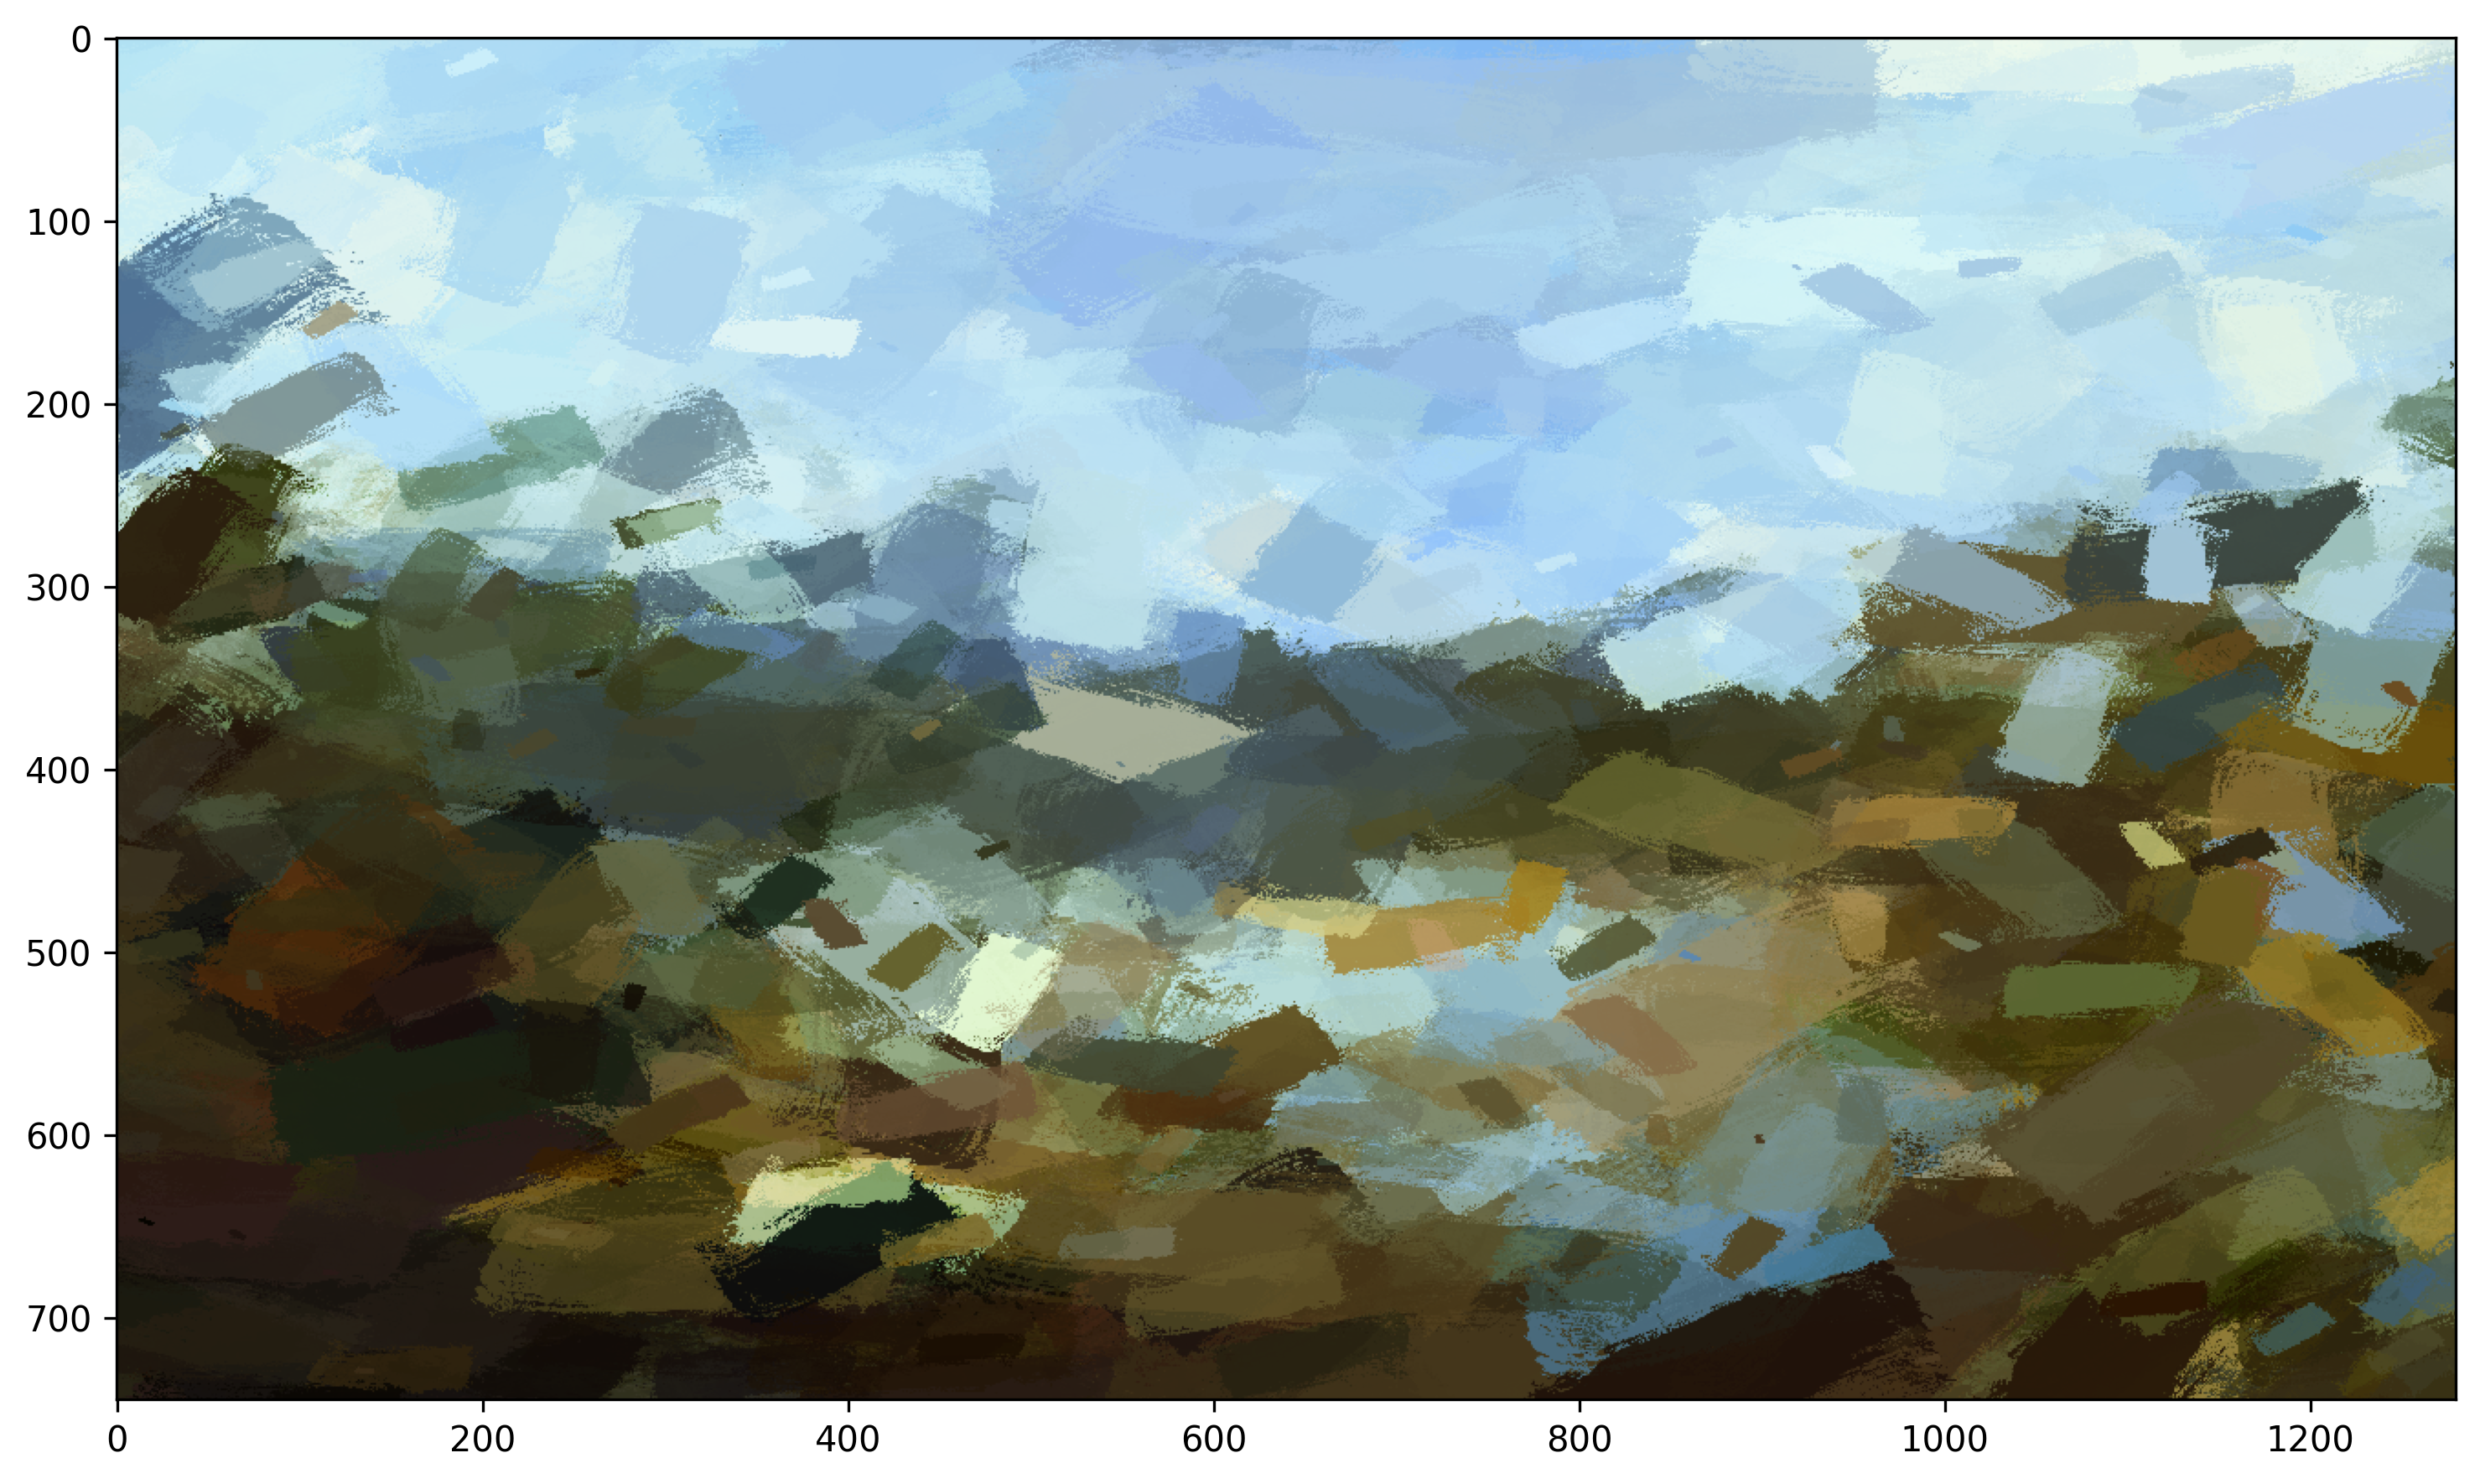

In [98]:
plt.figure(dpi=300).set_size_inches(12, 12)
plt.imshow(current_image[0, :].permute(1, 2, 0).cpu().numpy())